In [1]:
import sys, os, platform, random, math, time, json, shutil, zipfile, glob
from pathlib import Path
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from PIL import Image
import matplotlib.pyplot as plt



Train inputs: 8 | Train outputs: 56
Val inputs: 4 | Val outputs: 5
Training pairs: 56 | Validation pairs: 5
{'input_polygon': 'octagon.png', 'colour': 'cyan', 'output_image': 'cyan_octagon.png'}


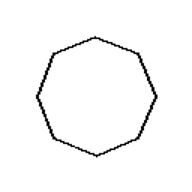

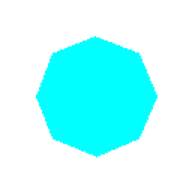

In [2]:
zip_path = "/content/dataset.zip"
root = Path("/content")
assert os.path.exists(zip_path), "dataset.zip not found in /content. Use one of the options above to place it here."

with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(root)

base_dir = root / "dataset"
train_inputs = base_dir / "training" / "inputs"
train_outputs = base_dir / "training" / "outputs"
train_json = base_dir / "training" / "data.json"

val_inputs = base_dir / "validation" / "inputs"
val_outputs = base_dir / "validation" / "outputs"
val_json = base_dir / "validation" / "data.json"
print("Train inputs:", len(list(train_inputs.glob("*.png"))),
      "| Train outputs:", len(list(train_outputs.glob("*.png"))))
print("Val inputs:", len(list(val_inputs.glob("*.png"))),
      "| Val outputs:", len(list(val_outputs.glob("*.png"))))
with open(train_json, 'r') as f:
    train_map = json.load(f)
with open(val_json, 'r') as f:
    val_map = json.load(f)

print("Training pairs:", len(train_map), "| Validation pairs:", len(val_map))

print(train_map[0])
display(Image.open(train_inputs / train_map[0]["input_polygon"]).convert("RGBA").resize((192,192)))
display(Image.open(train_outputs / train_map[0]["output_image"]).convert("RGBA").resize((192,192)))

In [3]:
from collections import defaultdict
import numpy as np
def most_frequent_color(img_rgba):
    arr = np.array(img_rgba)
    rgb = arr[:,:,:3]
    mask = ~(rgb == 255).all(-1)
    if mask.sum() == 0:
        return (255, 255, 255)
    colors, counts = np.unique(rgb[mask].reshape(-1, 3), axis=0, return_counts=True)
    return tuple(colors[counts.argmax()].tolist())
color_to_rgb = {}
seen = set()
for rec in train_map:
    cname = rec["colour"]
    out_img = Image.open(train_outputs / rec["output_image"]).convert("RGBA")
    rgb = most_frequent_color(out_img)
    if cname not in color_to_rgb:
        color_to_rgb[cname] = rgb
print("Color mapping inferred from training outputs:")
for k,v in color_to_rgb.items():
    print(f"{k:>8} -> {v}")


Color mapping inferred from training outputs:
    cyan -> (0, 255, 255)
  purple -> (128, 0, 128)
 magenta -> (255, 0, 255)
   green -> (0, 255, 0)
     red -> (255, 0, 0)
    blue -> (0, 0, 255)
  yellow -> (255, 255, 0)
  orange -> (255, 165, 0)


In [4]:
class PolygonColorDataset(Dataset):
    def __init__(self, base_dir, records, split="train", color_to_rgb=None, augment=True, out_size=128, add_synthetic=False, synthetic_factor=2):
        self.base_dir = Path(base_dir)
        self.split = split
        self.augment = augment and (split == "train")
        self.out_size = out_size
        self.color_to_rgb = color_to_rgb or {}
        self.add_synthetic = add_synthetic and (split == "train")
        self.synthetic_factor = synthetic_factor
        self.inputs_dir = self.base_dir / split / "inputs"
        self.outputs_dir = self.base_dir / split / "outputs"
        self.records = list(records)
        if self.add_synthetic and self.synthetic_factor > 1:
            self.records = self.records * self.synthetic_factor
        colors = sorted(self.color_to_rgb.keys())
        self.color_to_idx = {c:i for i,c in enumerate(colors)}
        self.idx_to_color = {i:c for c,i in self.color_to_idx.items()}
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.records)

    def _paired_affine(self, img_in, img_out):

        angle = random.uniform(-20, 20)
        translate = (random.uniform(-5, 5), random.uniform(-5, 5))
        scale = random.uniform(0.9, 1.1)
        shear = random.uniform(-8, 8)
        img_in = TF.affine(img_in, angle=angle, translate=translate, scale=scale, shear=shear, interpolation=transforms.InterpolationMode.BILINEAR, fill=(255,255,255))
        img_out = TF.affine(img_out, angle=angle, translate=translate, scale=scale, shear=shear, interpolation=transforms.InterpolationMode.BILINEAR, fill=(255,255,255))
        if random.random() < 0.5:
            img_in = TF.hflip(img_in)
            img_out = TF.hflip(img_out)
        if random.random() < 0.2:
            img_in = TF.vflip(img_in)
            img_out = TF.vflip(img_out)
        return img_in, img_out

    def __getitem__(self, idx):
        rec = self.records[idx]
        cin = self.inputs_dir / rec["input_polygon"]
        cout = self.outputs_dir / rec["output_image"]
        color_name = rec["colour"]


        def to_rgb(im):
            im = im.convert("RGBA")
            bg = Image.new("RGBA", im.size, (255,255,255,255))
            comp = Image.alpha_composite(bg, im)
            return comp.convert("RGB")

        inp = to_rgb(Image.open(cin))
        out = to_rgb(Image.open(cout))

        inp = inp.resize((self.out_size, self.out_size), Image.BILINEAR)
        out = out.resize((self.out_size, self.out_size), Image.BILINEAR)

        if self.augment:
            inp, out = self._paired_affine(inp, out)

        inp_t = self.to_tensor(inp)
        out_t = self.to_tensor(out)

        color_idx = self.color_to_idx[color_name]
        color_rgb = self.color_to_rgb[color_name]
        color_rgb_t = torch.tensor([c/255.0 for c in color_rgb], dtype=torch.float32)  # [3]

        sample = {
            "inp": inp_t,
            "target": out_t,
            "color_idx": torch.tensor(color_idx, dtype=torch.long),
            "color_rgb": color_rgb_t,
            "color_name": color_name
        }
        return sample


BATCH_SIZE = 16
OUT_SIZE = 128

train_ds = PolygonColorDataset(base_dir, train_map, split="training", color_to_rgb=color_to_rgb, augment=True, out_size=OUT_SIZE, add_synthetic=True, synthetic_factor=4)
val_ds   = PolygonColorDataset(base_dir, val_map,   split="validation", color_to_rgb=color_to_rgb, augment=False, out_size=OUT_SIZE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds), len(train_loader), len(val_loader)

(56, 5, 4, 1)

In [5]:
class FiLM(nn.Module):

    def __init__(self, cond_dim, num_channels):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(cond_dim, num_channels*2),
            nn.SiLU(),
            nn.Linear(num_channels*2, num_channels*2)
        )
    def forward(self, x, cond_vec):

        h = self.fc(cond_vec)
        gamma, beta = torch.chunk(h, 2, dim=1)
        gamma = gamma.view(x.size(0), x.size(1), 1, 1)
        beta  = beta.view(x.size(0), x.size(1), 1, 1)
        return gamma, beta

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, cond_dim=None, use_film=True):
        super().__init__()
        self.use_film = use_film and (cond_dim is not None)
        self.gn1 = nn.GroupNorm(num_groups=8, num_channels=out_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.gn2 = nn.GroupNorm(num_groups=8, num_channels=out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.act = nn.SiLU()
        if self.use_film:
            self.film1 = FiLM(cond_dim, out_ch)
            self.film2 = FiLM(cond_dim, out_ch)

    def forward(self, x, cond_vec=None):
        x = self.conv1(x)
        x = self.gn1(x)
        if self.use_film and cond_vec is not None:
            g,b = self.film1(x, cond_vec); x = g * x + b
        x = self.act(x)
        x = self.conv2(x)
        x = self.gn2(x)
        if self.use_film and cond_vec is not None:
            g,b = self.film2(x, cond_vec); x = g * x + b
        x = self.act(x)
        return x

class UNetCond(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, base_ch=32, cond_method="film", num_colors=8, cond_dim=32):
        super().__init__()
        self.cond_method = cond_method
        self.num_colors = num_colors
        self.color_emb = nn.Embedding(num_colors, cond_dim)


        extra_in = 0
        if cond_method == "concat_rgb":
            extra_in = 3
        elif cond_method == "concat_idx":
            extra_in = cond_dim


        self.down1 = ConvBlock(in_ch + extra_in, base_ch, cond_dim=cond_dim, use_film=(cond_method=="film"))
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = ConvBlock(base_ch, base_ch*2, cond_dim=cond_dim, use_film=(cond_method=="film"))
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = ConvBlock(base_ch*2, base_ch*4, cond_dim=cond_dim, use_film=(cond_method=="film"))
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = ConvBlock(base_ch*4, base_ch*8, cond_dim=cond_dim, use_film=(cond_method=="film"))


        self.up3 = nn.ConvTranspose2d(base_ch*8, base_ch*4, 2, stride=2)
        self.up_block3 = ConvBlock(base_ch*8, base_ch*4, cond_dim=cond_dim, use_film=(cond_method=="film"))

        self.up2 = nn.ConvTranspose2d(base_ch*4, base_ch*2, 2, stride=2)
        self.up_block2 = ConvBlock(base_ch*4, base_ch*2, cond_dim=cond_dim, use_film=(cond_method=="film"))

        self.up1 = nn.ConvTranspose2d(base_ch*2, base_ch, 2, stride=2)
        self.up_block1 = ConvBlock(base_ch*2, base_ch, cond_dim=cond_dim, use_film=(cond_method=="film"))

        self.final = nn.Conv2d(base_ch, out_ch, 1)

    def forward(self, img, color_idx, color_rgb):

        B, C, H, W = img.shape
        cond_vec = self.color_emb(color_idx)

        x = img
        if self.cond_method == "concat_rgb":
            rgb_map = color_rgb.view(B,3,1,1).expand(B,3,H,W)
            x = torch.cat([x, rgb_map], dim=1)
        elif self.cond_method == "concat_idx":
            emb = cond_vec.view(B,-1,1,1).expand(B,cond_vec.size(1),H,W)
            x = torch.cat([x, emb], dim=1)


        d1 = self.down1(x, cond_vec if self.cond_method=="film" else None)
        p1 = self.pool1(d1)
        d2 = self.down2(p1, cond_vec if self.cond_method=="film" else None)
        p2 = self.pool2(d2)
        d3 = self.down3(p2, cond_vec if self.cond_method=="film" else None)
        p3 = self.pool3(d3)

        b = self.bottleneck(p3, cond_vec if self.cond_method=="film" else None)


        u3 = self.up3(b)
        u3 = torch.cat([u3, d3], dim=1)
        u3 = the3 = self.up_block3(u3, cond_vec if self.cond_method=="film" else None)

        u2 = self.up2(u3)
        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.up_block2(u2, cond_vec if self.cond_method=="film" else None)

        u1 = self.up1(u2)
        u1 = torch.cat([u1, d1], dim=1)
        u1 = self.up_block1(u1, cond_vec if self.cond_method=="film" else None)

        out = self.final(u1)
        out = torch.sigmoid(out)
        return out


In [7]:
def psnr(mse, max_val=1.0):

    return 20 * torch.log10(torch.tensor(max_val)) - 10 * torch.log10(mse + 1e-8)

def compute_metrics(pred, target):
    with torch.no_grad():
        mse = F.mse_loss(pred, target)
        l1 = F.l1_loss(pred, target)
        return {
            "mse": mse.item(),
            "l1": l1.item(),
            "psnr": psnr(mse).item(),
        }

def show_batch(batch, preds=None, max_n=6, figsize=(12, 6)):
    inp = batch["inp"].cpu()
    tgt = batch["target"].cpu()
    color_names = batch["color_name"]
    n = min(inp.size(0), max_n)
    rows = 1 if preds is None else 3

    fig, axs = plt.subplots(rows, n, figsize=figsize)
    if rows == 1:
        axs = np.expand_dims(axs, axis=0)

    for i in range(n):
        axs[0, i].imshow(np.transpose(inp[i].numpy(), (1, 2, 0)))
        axs[0, i].axis('off')
        axs[0, i].set_title(f"Input\n({color_names[i]})")

        if preds is not None:
            axs[1, i].imshow(np.transpose(preds[i].detach().cpu().numpy(), (1, 2, 0)))
            axs[1, i].axis('off')
            axs[1, i].set_title("Prediction")

            axs[2, i].imshow(np.transpose(tgt[i].numpy(), (1, 2, 0)))
            axs[2, i].axis('off')
            axs[2, i].set_title("Ground Truth")

    plt.tight_layout()
    plt.show()


/tmp/ipython-input-2489252571.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sreejabommagani2005 (sreejabommagani2005-mahindra-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/tmp/ipython-input-2489252571.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


{'epoch': 1, 'time_s': 2.9920449256896973, 'loss': 0.4053225591778755, 'mse': 0.23544500395655632, 'l1': 0.47812723368406296, 'psnr': 6.281104564666748, 'val_loss': 0.39867398142814636, 'val_mse': 0.22535157203674316, 'val_l1': 0.47295501828193665, 'val_psnr': 6.471393585205078}
{'epoch': 2, 'time_s': 0.4928286075592041, 'loss': 0.38468455523252487, 'mse': 0.21503007784485817, 'l1': 0.4573936313390732, 'psnr': 6.6750078201293945, 'val_loss': 0.3788484036922455, 'val_mse': 0.2073172628879547, 'val_l1': 0.45236173272132874, 'val_psnr': 6.833644866943359}
{'epoch': 3, 'time_s': 0.5095663070678711, 'loss': 0.36303894966840744, 'mse': 0.1962045207619667, 'l1': 0.43453941494226456, 'psnr': 7.072909355163574, 'val_loss': 0.3573949933052063, 'val_mse': 0.18872793018817902, 'val_l1': 0.42968085408210754, 'val_psnr': 7.241637706756592}
{'epoch': 4, 'time_s': 0.49253320693969727, 'loss': 0.34165123850107193, 'mse': 0.17851818725466728, 'l1': 0.4115654081106186, 'psnr': 7.483174800872803, 'val_los

/tmp/ipython-input-2489252571.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


{'epoch': 13, 'time_s': 1.0396616458892822, 'loss': 0.1089946050196886, 'mse': 0.0685384701937437, 'l1': 0.1263329479843378, 'psnr': 11.640654563903809, 'val_loss': 0.09012410044670105, 'val_mse': 0.0446380078792572, 'val_l1': 0.10961814224720001, 'val_psnr': 13.502950668334961}
{'epoch': 14, 'time_s': 0.5097565650939941, 'loss': 0.10272464156150818, 'mse': 0.06776285264641047, 'l1': 0.11770826950669289, 'psnr': 11.690082550048828, 'val_loss': 0.07678645104169846, 'val_mse': 0.03859291970729828, 'val_l1': 0.09315511584281921, 'val_psnr': 14.13492202758789}
{'epoch': 15, 'time_s': 0.5118060111999512, 'loss': 0.09385838732123375, 'mse': 0.06461395230144262, 'l1': 0.10639171674847603, 'psnr': 11.896736145019531, 'val_loss': 0.0755588561296463, 'val_mse': 0.044987648725509644, 'val_l1': 0.08866079896688461, 'val_psnr': 13.46906566619873}
{'epoch': 16, 'time_s': 0.5215198993682861, 'loss': 0.08241427317261696, 'mse': 0.057123043574392796, 'l1': 0.09325337037444115, 'psnr': 12.43188667297363

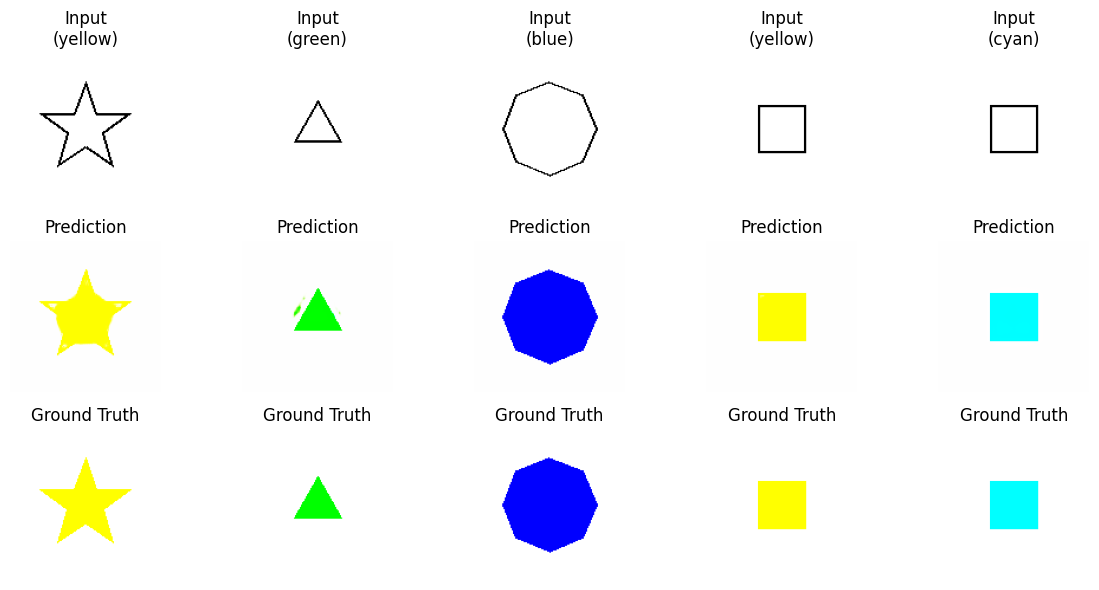

Best checkpoint saved at: /content/cond_unet_film.pt


In [8]:
import torch
import wandb
import time

EPOCHS = 150  #@param {type:"integer"}
LR = 1e-3     #@param {type:"number"}
BASE_CH = 32  #@param {type:"integer"}
COND_METHOD = "film"  #@param ["film", "concat_rgb", "concat_idx"]
WANDB_PROJECT = "ayna-conditional-unet"  #@param {type:"string"}
USE_WANDB = True  #@param {type:"boolean"}


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


try:
    import wandb
    WANDB_AVAILABLE = True
except ImportError:
    WANDB_AVAILABLE = False


num_colors = len(train_ds.color_to_idx)
model = UNetCond(in_ch=3, out_ch=3, base_ch=BASE_CH, cond_method=COND_METHOD, num_colors=num_colors, cond_dim=32).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

if USE_WANDB and WANDB_AVAILABLE:

    wandb.init(project=WANDB_PROJECT, config={
        "epochs": EPOCHS,
        "lr": LR,
        "batch_size": BATCH_SIZE,
        "base_ch": BASE_CH,
        "cond_method": COND_METHOD,
        "augment": True,
        "out_size": OUT_SIZE,
    })
    wandb.watch(model, log="gradients", log_freq=50)
else:
    print("W&B disabled or not available.")

best_val = float('inf')
save_path = f"/content/cond_unet_{COND_METHOD}.pt"

for epoch in range(1, EPOCHS+1):
    model.train()
    t0 = time.time()
    running = {"loss":0.0, "mse":0.0, "l1":0.0}
    for batch in train_loader:
        img = batch["inp"].to(device)
        tgt = batch["target"].to(device)
        color_idx = batch["color_idx"].to(device)
        color_rgb = batch["color_rgb"].to(device)

        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            pred = model(img, color_idx, color_rgb)
            loss = F.l1_loss(pred, tgt) * 0.7 + F.mse_loss(pred, tgt) * 0.3
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        m = compute_metrics(pred.detach(), tgt)
        running["loss"] += loss.item()
        running["mse"]  += m["mse"]
        running["l1"]   += m["l1"]

    n_batches = max(1, len(train_loader))
    train_log = {k: v/n_batches for k,v in running.items()}

    model.eval()
    with torch.no_grad():
        val_running = {"loss":0.0, "mse":0.0, "l1":0.0}
        all_preds = []
        for batch in val_loader:
            img = batch["inp"].to(device)
            tgt = batch["target"].to(device)
            color_idx = batch["color_idx"].to(device)
            color_rgb = batch["color_rgb"].to(device)
            pred = model(img, color_idx, color_rgb)
            loss = F.l1_loss(pred, tgt) * 0.7 + F.mse_loss(pred, tgt) * 0.3
            m = compute_metrics(pred, tgt)
            val_running["loss"] += loss.item()
            val_running["mse"]  += m["mse"]
            val_running["l1"]   += m["l1"]
            all_preds.append(pred.cpu())
        n_val_batches = max(1, len(val_loader))
        val_log = {f"val_{k}": v/n_val_batches for k,v in val_running.items()}


    train_log["psnr"] = psnr(torch.tensor(train_log["mse"])).item()
    val_log["val_psnr"] = psnr(torch.tensor(val_log["val_mse"])).item()
    elapsed = time.time() - t0

    log = {"epoch": epoch, "time_s": elapsed, **train_log, **val_log}
    print(log)

    if USE_WANDB and WANDB_AVAILABLE:
        wandb.log(log)

    if val_log["val_loss"] < best_val:
        best_val = val_log["val_loss"]
        torch.save({"model": model.state_dict(),
                    "color_to_idx": train_ds.color_to_idx,
                    "idx_to_color": train_ds.idx_to_color,
                    "color_to_rgb": color_to_rgb,
                    "hparams": {"base_ch": BASE_CH, "cond_method": COND_METHOD, "out_size": OUT_SIZE}}, save_path)

batch = next(iter(val_loader))
model.eval()
with torch.no_grad():
    preds = model(batch["inp"].to(device), batch["color_idx"].to(device), batch["color_rgb"].to(device))
show_batch(batch, preds, max_n=min(6, batch["inp"].size(0)))
print("Best checkpoint saved at:", save_path)

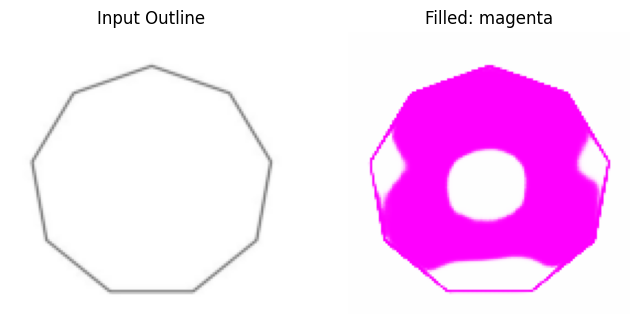

In [9]:
from PIL import Image
import torch

test_img_path = "/content/nanogon.jpeg"
color_name = "magenta"
ckpt_path = "/content/cond_unet_film.pt"
ckpt = torch.load(ckpt_path, map_location=device)
color_to_idx = ckpt["color_to_idx"]
idx_to_color = ckpt["idx_to_color"]
color_to_rgb = ckpt["color_to_rgb"]
hparams = ckpt["hparams"]


model = UNetCond(
    in_ch=3, out_ch=3, base_ch=hparams["base_ch"],
    cond_method=hparams["cond_method"], num_colors=len(color_to_idx), cond_dim=32
).to(device)
model.load_state_dict(ckpt["model"])
model.eval()


def to_rgb(im):
    im = im.convert("RGBA")
    bg = Image.new("RGBA", im.size, (255,255,255,255))
    comp = Image.alpha_composite(bg, im)
    return comp.convert("RGB")

test_img = to_rgb(Image.open(test_img_path))
test_img = test_img.resize((hparams["out_size"], hparams["out_size"]), Image.BILINEAR)
x = transforms.ToTensor()(test_img).unsqueeze(0).to(device)

assert color_name in color_to_idx, f"Unknown color '{color_name}'. Available: {list(color_to_idx.keys())}"
cidx = torch.tensor([color_to_idx[color_name]], dtype=torch.long, device=device)
crgb = torch.tensor([[c / 255.0 for c in color_to_rgb[color_name]]], dtype=torch.float32, device=device)

with torch.no_grad():
    y = model(x, cidx, crgb)
    y_img = (y.squeeze(0).cpu().clamp(0, 1).numpy().transpose(1, 2, 0))
    out_img = Image.fromarray((y_img * 255).astype('uint8'))

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(test_img)
plt.title("Input Outline")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(out_img)
plt.title(f"Filled: {color_name}")
plt.axis("off")
plt.show()
